# 主題 : Retraining an Image Classifier

file     : tf2_image_retraining_revised.ipynb

revised   : Ming-Chang Lee

date     : 2025.11.19

YouTube  : https://www.youtube.com/@alan9956

RWEPA    : http://rwepa.blogspot.tw/

GitHub   : https://github.com/rwepa

Email    : alan9956@gmail.com

source: https://www.tensorflow.org/hub/tutorials/tf2_image_retraining

# 載入模組

In [1]:
import time
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

# 顯示版本
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")


TF version: 2.20.0
Hub version: 0.16.1
GPU is NOT AVAILABLE


# 選取 TF2 儲存模型

For starters, use [https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4). The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that models in TF1 Hub format won't work here.)

You can find more TF2 models that generate image feature vectors [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2).

There are multiple possible models to try. All you need to do is select a different one on the cell below and follow up with the notebook.

In [2]:
model_name = "efficientnetv2-xl-21k" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

Selected model: efficientnetv2-xl-21k : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2
Input size (512, 512)


In [3]:
BATCH_SIZE = 16 #@param {type:"integer"}

# 下載花卉資料集

輸入影像會根據所選模組進行適當調整大小。資料集增強（即每次讀取影像時都對其進行隨機失真處理）可以改善訓練效果，尤其是在微調階段。

In [4]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
print(data_dir) # 5個資料夾, 3670個檔案

C:\Users\User\.keras\datasets\flower_photos


# 花卉資料夾 C:\Users\User\\.keras\datasets\flower_photos\flower_photos 

<img src="https://raw.githubusercontent.com/rwepa/propeller_design/refs/heads/main/imgs/flower_photos_directory.png" width="500">

# 鬱金香 tulips

<img src="https://raw.githubusercontent.com/rwepa/propeller_design/refs/heads/main/imgs/tulips.png" width="500">

# 資料處理

In [5]:
def build_dataset(subset):
  return tf.keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False #@param {type:"boolean"}

if do_data_augmentation:
  preprocessing_model.add(
      tf.keras.layers.RandomRotation(40))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomTranslation(0.2, 0))
  # Like the old tf.keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      tf.keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 3670 files belonging to 1 classes.
Using 2936 files for training.
Found 3670 files belonging to 1 classes.
Using 734 files for validation.


# 定義模型

All it takes is to put a linear classifier(線性分類器) on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [6]:
"""
do_fine_tuning = False 設定布林值 False 表示模型不要進行微調（fine-tuning）。即使用預訓練模型的特徵，不再進一步訓練。

#@param {type:"boolean"}

此為 Colab（Google Colaboratory） 的「參數化控制」語法註解。
結果會讓這個變數在 Colab 介面中變成一個可勾選的「布林選項框」。
用來讓程式變得互動式，方便使用者切換參數。
☑️ do_fine_tuning
"""

do_fine_tuning = False #@param {type:"boolean"}

In [7]:
print("Building model with", model_handle)

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2


In [8]:
# 原始 Tensorflow 網站提供之程式碼會有錯誤
# model = tf.keras.Sequential([
#     # Explicitly define the input shape so the model can be properly loaded by the TFLiteConverter
#     # tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
#     # UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
#     # 上面程式碼改為直接使用 shape.
#     tf.keras.layers.InputLayer(shape=IMAGE_SIZE + (3,)),
#     hub.KerasLayer(model_handle, trainable=do_fine_tuning),
#     tf.keras.layers.Dropout(rate=0.2),
#     tf.keras.layers.Dense(len(class_names),
#                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
# ])

# ValueError: Only instances of `keras.Layer` can be added to a Sequential model.
# Received: <tensorflow_hub.keras_layer.KerasLayer object at 0x00000207873CEE40> (of type <class 'tensorflow_hub.keras_layer.KerasLayer'>)

In [9]:
# 修改使用 wrapper tf.keras.layers.Layer 把 Hub 層包裝起來
# 在自訂 Layer 的 __init__ 中建立一次 hub.KerasLayer，然後再 call() 中呼叫它。
# 修改後會將 hub 層正確地當成 Keras 子層處理，避免在 graph 建構期間做不允許的 NumPy 操作。

class HubWrapper(tf.keras.layers.Layer):
    def __init__(self, handle, trainable=False, **kwargs):
        super().__init__(**kwargs)
        # 在 __init__ 建立 hub 層（只建立一次）
        self.hub = hub.KerasLayer(handle, trainable=trainable)

    def call(self, inputs, training=False):
        # 這裡僅呼叫預先建立好的 hub 層
        return self.hub(inputs, training=training)

In [10]:
# 使用 Functional API
inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,))
x = HubWrapper(model_handle, trainable=do_fine_tuning)(inputs)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(class_names),kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
model = tf.keras.Model(inputs, outputs)
# WARNING:tensorflow:From C:\Users\User\anaconda3\Lib\site-packages\tensorflow_hub\resolver.py:120: 
# The name tf.gfile.MakeDirs is deprecated. Please use tf.io.gfile.makedirs instead.

In [11]:
model.build((None,) + IMAGE_SIZE + (3,)) # IMAGE_SIZE=(512, 512)

In [12]:
# 模型摘要
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 512, 512, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hub_wrapper (HubWrapper)             │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,281 (5.00 KB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 0 (0.00 B)

# 訓練模型

In [13]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [14]:
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
print(steps_per_epoch)
print(validation_steps)

183
45


In [15]:
start = time.time()
hist = model.fit(
    train_ds,
    epochs=5, 
    steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history
end = time.time()
print("執行時間:", end - start, "秒") # 21344.19963979721 秒 ~ 358分 ~ 6小時

Epoch 1/5


C:\Users\User\anaconda3\Lib\site-packages\keras\src\losses\losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


183/183 ━━━━━━━━━━━━━━━━━━━━ 3839s 21s/step - accuracy: 0.4071 - loss: 2.0062e-04 - val_accuracy: 0.4111 - val_loss: 2.0025e-04
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 3938s 22s/step - accuracy: 0.4205 - loss: 1.9989e-04 - val_accuracy: 0.4111 - val_loss: 1.9952e-04
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 4038s 22s/step - accuracy: 0.4000 - loss: 1.9916e-04 - val_accuracy: 0.4097 - val_loss: 1.9879e-04
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 4036s 22s/step - accuracy: 0.4147 - loss: 1.9843e-04 - val_accuracy: 0.4097 - val_loss: 1.9806e-04
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 4109s 22s/step - accuracy: 0.4089 - loss: 1.9770e-04 - val_accuracy: 0.4097 - val_loss: 1.9734e-04
執行時間: 19959.613489866257 秒


# 繪製訓練集與驗證集損失圖

In [16]:
hist # dict

{'accuracy': [0.40710383653640747,
  0.4205479323863983,
  0.4000000059604645,
  0.41472601890563965,
  0.408904105424881],
 'loss': [0.00020061832037754357,
  0.0001998862426262349,
  0.00019915599841624498,
  0.00019842837355099618,
  0.00019770338258240372],
 'val_accuracy': [0.41111111640930176,
  0.41111111640930176,
  0.4097222089767456,
  0.4097222089767456,
  0.4097222089767456],
 'val_loss': [0.00020025121921207756,
  0.00019951963622588664,
  0.00019879078899975866,
  0.00019806438649538904,
  0.0001973407343029976]}

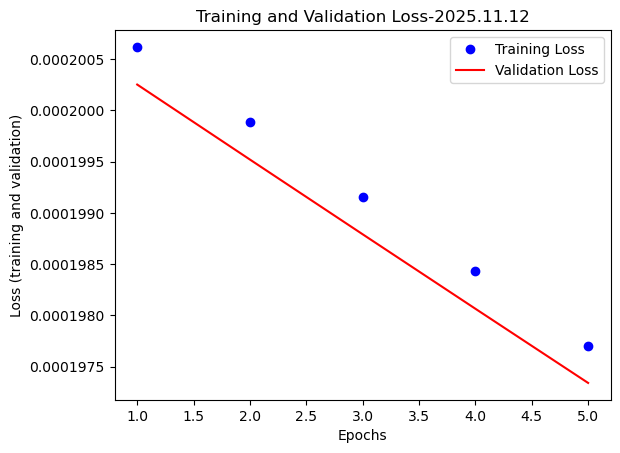

In [17]:
epochs = range(1, len(hist["loss"])+1)
plt.plot(epochs, hist["loss"], "bo", label="Training Loss")
plt.plot(epochs, hist["val_loss"], "r", label="Validation Loss")
plt.title("Training and Validation Loss-2025.11.12")
plt.xlabel("Epochs")
plt.ylabel("Loss (training and validation)")
plt.legend()
plt.show()

# 繪製訓練集與驗證集準確圖

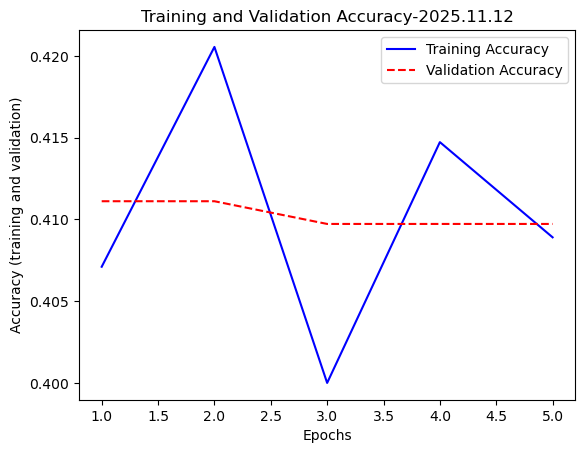

In [18]:
plt.plot(epochs, hist["accuracy"], "b-", label="Training Accuracy")
plt.plot(epochs, hist["val_accuracy"], "r--", label="Validation Accuracy")
plt.title("Training and Validation Accuracy-2025.11.12")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (training and validation)")
plt.legend()
plt.show()

# 顯示驗證資料集的圖片

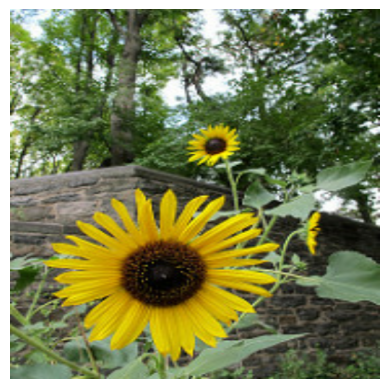

1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
True label: flower_photos
Predicted label: flower_photos


In [19]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])

# 儲存訓練好的模型

In [20]:
saved_model_path = f"saved_flowers_model_{model_name}.keras"
# tf.saved_model.save(model, saved_model_path)
# TypeError: this __dict__ descriptor does not support '_DictWrapper' objects
model.save(saved_model_path)

In [21]:
# end